In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load initially processed tide gauge records in GOM and along U.S. east coast 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/natl_gauges_1970_2021.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
id_tags_east_coast = ['PORTLAND','BOSTON','WOODS HOLE (OCEAN. INST.)','MONTAUK','SANDY HOOK',\
                     'ATLANTIC CITY','CAPE MAY','KIPTOPEKE BEACH','SEWELLS POINT, HAMPTON ROADS',\
                     'OREGON INLET MARINA, NORTH CAROLINA','BEAUFORT','SPRINGMAID PIER','CHARLESTON I',\
                     'FORT PULASKI','FERNANDINA BEACH','LAKE WORTH PIER'];
id_tags_GOM = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH',\
               'CEDAR KEY II', 'APALACHICOLA','PANAMA CITY, ST.ANDREWS BAY, FL','PENSACOLA', \
               'DAUPHIN ISLAND','MOBILE STATE DOCKS, ALABAMA','BAY WAVELAND YACHT CLUB',\
               'SHELL BEACH, LOUISIANA','GRAND ISLE','SABINE PASS','GALVESTON II, PIER 21, TX',\
               'FREEPORT','CORPUS CHRISTI, GULF MEXICO, TX','PORT ISABEL']
id_tags = id_tags_east_coast + id_tags_GOM

In [3]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines(); file_int.close()
name = []; name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)
        
# -- processing to get one number per tide gauge site 
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [4]:
# - subset to remove mean from all years 
t_s = '1974-01-15'; t_e = '2020-10-31'
tg = data_da.sel(time=slice(t_s, t_e))
tg_a = tg - data_da.sel(time=slice(t_s, t_e)).mean(dim='time') # relative to 1993-2021 mean? 

In [5]:
# ---- tide gauge over longer time and w/o seasonal cycle 
ids = data_da.location.data
tg_time = tg.time.data
# - array of datetimes 
time_ord = np.nan*np.ones(len(tg_time))
for i in range(len(tg_time)):
    ts = (np.datetime64(str(tg_time[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
    
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [6]:
# consider this list of stations
# tcs = [0,1,2,3,5,6,8,13,15] 
tcs = np.concatenate((np.array([0,1,2,3,4,5,6,7,8,10,12,13,14]),np.array([0,1,2,3,5,6,8,13,15])+16))
tfd = 10                                 # (trend fit duration in years)
dtl = len(tg_time) - 365*tfd            # (time index when to stop trend fitting) 
# !! NEED TO STOP AT ABOVE INDEX BECAUSE IT IS THE _START_ OF THE DECADE ENDING AT THE END OF THE RECORD ... 2021
t_int = 28                              # (number of days between trend fits)
print(tg_time[dtl])
# print(data_da)

vlm_rate_2 = vlm_rate[tcs]

2010-11-04T00:00:00.000000000


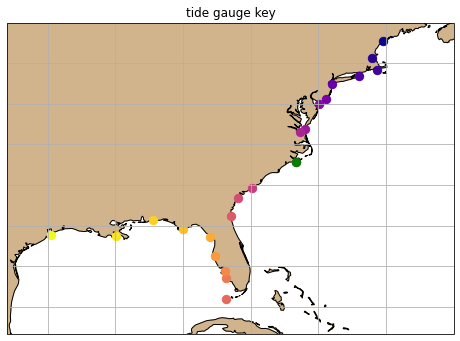

In [8]:
cc = plt.get_cmap('plasma',len(tcs))
f, ax = plt.subplots(1,1,figsize=(8,6),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tcs)):
    ax.scatter(data_da.lon[tcs[i]].data,data_da.lat[tcs[i]].data,s=70,color=cc(i),transform=ccrs.PlateCarree(),zorder=2)
split_index = id_tags.index('BEAUFORT')
ax.scatter(data_da.lon[split_index].data,data_da.lat[split_index].data,\
           s=70,color='g',transform=ccrs.PlateCarree(),zorder=2)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
gl.xlabels_bottom = False; gl.ylabels_left = False;
ax.set_xlim([-98,-65]); ax.set_ylim([22,45]);
ax.set_title('tide gauge key')
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_12_12_c_little/n_atl_gauges.jpg', dpi=300)

In [9]:
tg_trend_ts = np.nan*np.ones((len(tcs),len(range(0,dtl,t_int)))); count = 0; id_tags_2 = []
for st_i in tcs: 
    print(id_tags[st_i])
    id_tags_2.append(id_tags[st_i])
    this_tg = (tg_a.sel(location=ids[st_i])).interpolate_na(dim='time',method='linear')
    filt_len = 30 # smooth w/ boxcar filter length (days)
    this_tg_sm = np.convolve((1/filt_len)*np.ones(filt_len),this_tg)
    this_tg_sm = this_tg_sm[np.int(filt_len/2):-np.int(filt_len/2)+1]

    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], this_tg_sm)
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    this_tg_sm_wo_season = xr.DataArray(data=this_tg_sm - model, dims=["time"],
                            coords=dict(time=(["time"], tg_time)))
    # -- decadal trend in time 
    dec_tr_m = []; dec_tr_t_m = []
    for i in range(0,dtl,t_int): 
        # -- OPTION 1: linear trend fit over time period of interest 
        this_slice = this_tg_sm_wo_season[i:i+365*tfd] # fit trend over 10 year period
        # dt0 = this_slice.polyfit(dim='time', deg=1)
        # dec_tr.append((dt0.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365)
        # dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        # -- OPTION 2: seasonal cycle and trend fit at each time period 
        this_t = time_ord[i:i+365*10]
        fit = curve_fit(seasonal_plus_trend, this_t - this_t[0], this_tg_sm[i:i+365*10])
        dec_tr_m.append(fit[0][4]*365) # linear trend
        dec_tr_t_m.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        
    if st_i < 1:
        time_master = dec_tr_t_m
    tg_trend_ts[count,:] = dec_tr_m
    count = count + 1

PORTLAND
BOSTON
WOODS HOLE (OCEAN. INST.)
MONTAUK
SANDY HOOK
ATLANTIC CITY
CAPE MAY
KIPTOPEKE BEACH
SEWELLS POINT, HAMPTON ROADS
BEAUFORT
CHARLESTON I
FORT PULASKI
FERNANDINA BEACH
KEY WEST
NAPLES
FORT MYERS
ST. PETERSBURG
CEDAR KEY II
APALACHICOLA
PENSACOLA
GRAND ISLE
GALVESTON II, PIER 21, TX


In [25]:
id_tags_3 = []
for st_i in tcs: 
    print(id_tags[st_i][0:12])
    id_tags_3.append(id_tags[st_i][0:12])

PORTLAND
BOSTON
WOODS HOLE (
MONTAUK
SANDY HOOK
ATLANTIC CIT
CAPE MAY
KIPTOPEKE BE
SEWELLS POIN
BEAUFORT
CHARLESTON I
FORT PULASKI
FERNANDINA B
KEY WEST
NAPLES
FORT MYERS
ST. PETERSBU
CEDAR KEY II
APALACHICOLA
PENSACOLA
GRAND ISLE
GALVESTON II


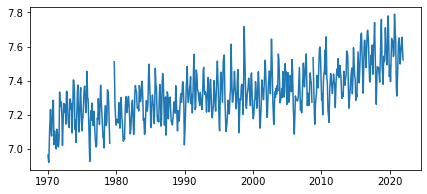

In [10]:
f, ax = plt.subplots(1,1,figsize=(7,3))
ax.plot(data_da.time, data_da.data[st_i,:])

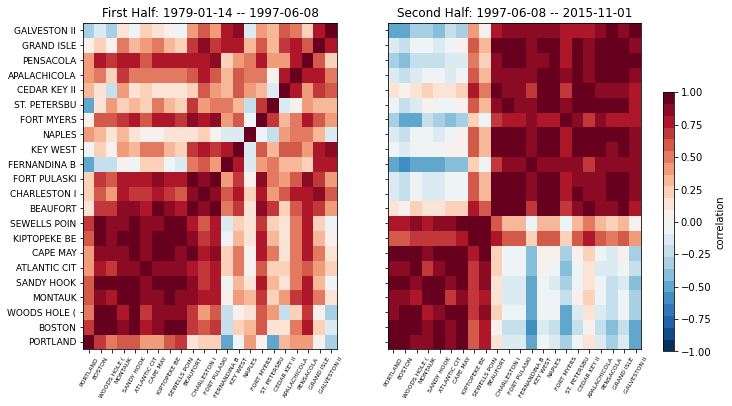

In [41]:
t_i_split = np.int(len(time_master)*(1/2))
corr_mat1 = np.corrcoef(tg_trend_ts[:,0:t_i_split])
corr_mat2 = np.corrcoef(tg_trend_ts[:,t_i_split:])

cm = plt.get_cmap('RdBu_r',len(tcs))
f, (ax,ax2) = plt.subplots(1,2,figsize=(10,6))
pc = ax.pcolor(np.arange(0,len(tcs)),np.arange(0,len(tcs)),corr_mat1,vmin=-1,vmax=1,cmap=cm,shading='interp')
ax.set_xticks(np.arange(0,len(tcs)));
ax.set_xticklabels(id_tags_3,fontsize=6,rotation=60);
ax.set_yticks(np.arange(0,len(tcs)));
ax.set_yticklabels(id_tags_3,fontsize=9,rotation=0);
ax.set_title('First Half: ' + str(time_master[0])[0:10] + ' -- ' + str(time_master[t_i_split])[0:10])

ax2.pcolor(np.arange(0,len(tcs)),np.arange(0,len(tcs)),corr_mat2,vmin=-1,vmax=1,cmap=cm,shading='interp')
ax2.set_xticks(np.arange(0,len(tcs)));
ax2.set_xticklabels(id_tags_3,fontsize=6,rotation=60);
ax2.set_yticks(np.arange(0,len(tcs)));
ax2.set_yticklabels('');
ax2.set_title('Second Half: ' + str(time_master[t_i_split])[0:10] + ' -- ' + str(time_master[-1])[0:10])

cbpos = [0.93, 0.12, 0.015, 0.6]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pc, cax=cax, orientation='vertical', extend='neither', label='correlation');
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_12_12_c_little/trend_corr_all_ttime.jpg', dpi=300)

9.205479452054794


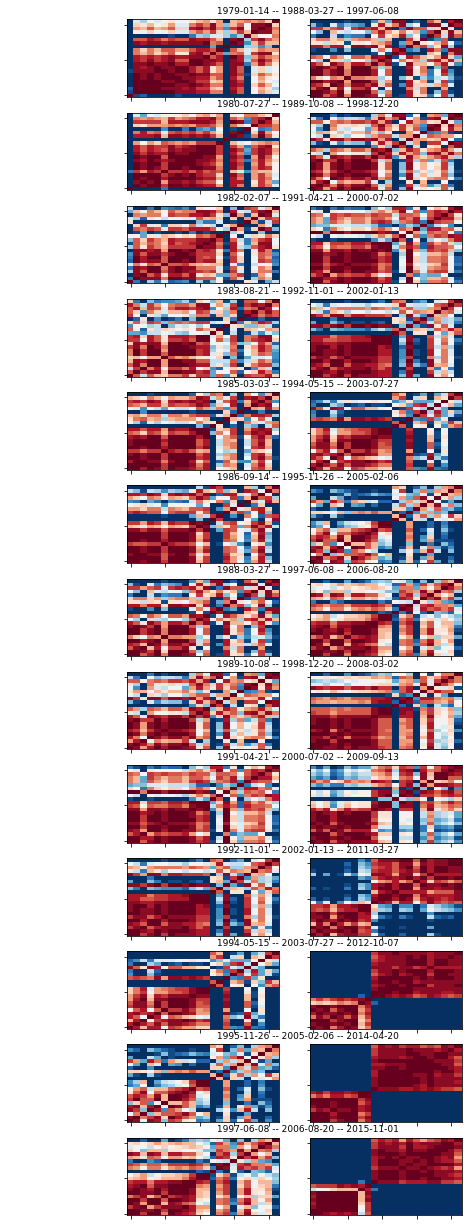

In [40]:
s_i = np.arange(len(time_master)*(1/4),len(time_master)*(3/4),20)
dur = np.int(s_i[0])
print(dur*t_int/365)
cm = plt.get_cmap('RdBu_r',len(tcs))
f, ax = plt.subplots(13,2,figsize=(6,22))
for i in range(13):
    corr_mat1 = np.corrcoef(tg_trend_ts[:,np.int(s_i[i])-dur:np.int(s_i[i])])
    corr_mat2 = np.corrcoef(tg_trend_ts[:,np.int(s_i[i]):np.int(s_i[i])+dur])
    ax[i,0].pcolor(np.arange(0,len(tcs)),np.arange(0,len(tcs)),corr_mat1,vmin=0,vmax=1,cmap=cm,shading='interp')
    ax[i,1].pcolor(np.arange(0,len(tcs)),np.arange(0,len(tcs)),corr_mat2,vmin=0,vmax=1,cmap=cm,shading='interp')  
    # ax[i,0].set_yticks(np.arange(0,len(tcs)));
    ax[i,0].set_yticklabels('');
    # ax[i,0].set_xticks(np.arange(0,len(tcs)));
    ax[i,0].set_xticklabels('');
    # ax[i,1].set_yticks(np.arange(0,len(tcs)));
    ax[i,1].set_yticklabels('');
    # ax[i,1].set_xticks(np.arange(0,len(tcs)));
    ax[i,1].set_xticklabels('');
    # ax[i,1].text(len(tcs)+5,np.int(len(tcs)/2),str(time_master[np.int(s_i[i])-dur])[0:10] + ' -- ' + \
    #             str(time_master[np.int(s_i[i])])[0:10] + ' -- ' + str(time_master[np.int(s_i[i])+dur])[0:10])
    ax[i,0].set_title('                                                                         ' + str(time_master[np.int(s_i[i])-dur])[0:10] + ' -- ' + \
                str(time_master[np.int(s_i[i])])[0:10] + ' -- ' + str(time_master[np.int(s_i[i])+dur])[0:10],fontsize=9)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_12_12_c_little/trend_corr_all_atime.jpg', dpi=300)

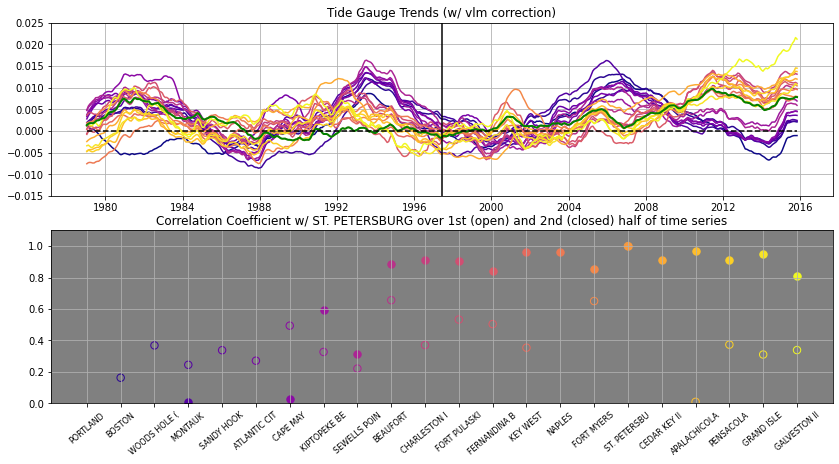

In [26]:
t_i_split = np.int(len(time_master)/2)
# --- STATION TO CORRELATE WITH
to_corr_index = id_tags_2.index('ST. PETERSBURG')
# to_corr_index = id_tags_2.index('NAPLES')
# to_corr_index = id_tags_2.index('WOODS HOLE (OCEAN. INST.)')
# to_corr_index = id_tags_2.index('CAPE MAY')

f, (ax,ax1) = plt.subplots(2,1,figsize=(14,7))
for i in range(np.shape(tg_trend_ts)[0]):
    ax.plot(time_master,tg_trend_ts[i,:] - vlm_rate_2[i],color=cc(i))
ax.plot(time_master,tg_trend_ts[to_corr_index,:] - vlm_rate_2[to_corr_index],color='g',linewidth=2)
ax.grid()
ax.plot([time_master[t_i_split],time_master[t_i_split]],[-0.015,0.025],color='k')
ax.plot(time_master,np.zeros(len(time_master)),color='k',linestyle='--')
ax.set_ylim([-0.015,0.025])

tg_stp_cov_1 = np.nan*np.ones(len(tcs)); tg_stp_cov_2 = np.nan*np.ones(len(tcs)); # xtl = []
for i in range(len(tcs)):
    covi = np.corrcoef(tg_trend_ts[i][0:t_i_split] - vlm_rate_2[i],\
                       tg_trend_ts[to_corr_index][0:t_i_split] - vlm_rate_2[to_corr_index])
    tg_stp_cov_1[i] = covi[0,1]
    covi = np.corrcoef(tg_trend_ts[i][t_i_split:] - vlm_rate_2[i],\
                       tg_trend_ts[to_corr_index][t_i_split:] - vlm_rate_2[to_corr_index])
    tg_stp_cov_2[i] = covi[0,1]
    ax1.scatter(i,tg_stp_cov_1[i],facecolors='none', edgecolors=cc(i),s=55)
    ax1.scatter(i,tg_stp_cov_2[i],color=cc(i),s=55)
    # xtl.append(id_tags[tcs[i]])

ax.set_title('Tide Gauge Trends (w/ vlm correction)')
ax1.set_title('Correlation Coefficient w/ ' + id_tags_2[to_corr_index] + \
              ' over 1st (open) and 2nd (closed) half of time series')
ax1.set_ylim([0,1.1])
ax1.set_xticks(np.arange(0,len(tcs)))
ax1.set_xticklabels(id_tags_3,fontsize=8,rotation=40)
ax1.set_facecolor(color='#808080')
ax1.grid()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_12_12_c_little/trend_corr_st_pete.jpg', dpi=300)